In [527]:
import numpy as np
from numpy import typing as npt
from numpy import random as rnd
from collections.abc import Callable, Sequence
from pyclugen import clugen
import matplotlib.pyplot as plt

In [528]:
def sigm(x: float):
    return 1.0 / (1 + np.exp(-x))

vsigm = np.vectorize(sigm)


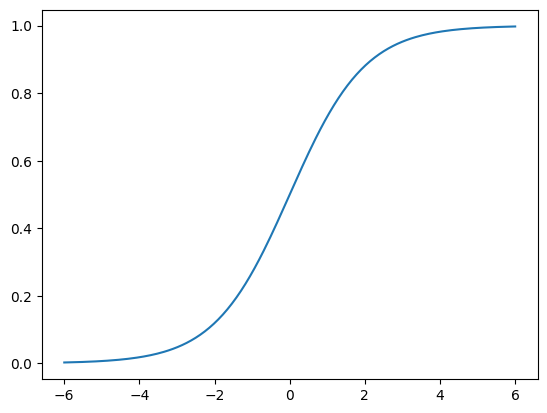

In [529]:
x = np.linspace(-6, 6, 200)
fig, ax = plt.subplots()
ax.plot(x, vsigm(x))

In [530]:
def infer(input: npt.NDArray, nn: list[npt.NDArray]) -> list[npt.NDArray]:

    output = [input]

    for layer in range(len(nn)):
        input = np.hstack((1, output[layer]))
        #output.append(vsigm(input @ nn[layer]))
        
        # For each node
        nodes_output = np.zeros(nn[layer].shape[1])
        for i in range(nn[layer].shape[1]):
            o = 0
            # For each input to that node
            for j in range(nn[layer].shape[0]):

                # Multiply input by respective weight
                o += input[j] * nn[layer][j, i]
            
            # Rectify and keep output
            nodes_output[i] = sigm(o)

        output.append(nodes_output)

    return output


In [531]:
# Determine fitness (0-1)
def avgfitness(expected: npt.NDArray, actual: npt.NDArray) -> float:
    correct = np.sum(np.apply_along_axis(np.all, 1, actual == expected))
    return correct / expected.shape[0]

In [532]:
# Use this for keeping track of fitness evolution during training
class FitnessRegister:
    def __init__(self, test_data: npt.NDArray, expect_out: npt.NDArray, iters: int):
        self.test_data = test_data
        self.expect_out = expect_out
        self.i = 0
        self.fitnesses = np.zeros(iters)

    def register(self, nn: npt.NDArray):
        # Determine fitness after current iteration
        actual_out = np.zeros(self.expect_out.shape)
        for j in range(actual_out.shape[0]):
            result = infer(self.test_data[j, :], nn)[-1]
            actual_out[j, np.argmax(result)] = 1
                    
        self.fitnesses[self.i] = avgfitness(self.expect_out, actual_out)
        self.i += 1


In [533]:
def backpropagation(
    train_input: npt.NDArray,
    train_output: npt.NDArray,
    topol: Sequence[int],
    iters: int,
    eta: float,
    momentum: float = 0,
    hooks: Sequence[Callable[[npt.NDArray], None]] = [],
    seed: int = 123,
):
    rng = rnd.default_rng(seed)

    # Create fully connected feed-forward network
    nn = []
    mm = [] # Momentum
    for j in range(len(topol) - 1):
        nn.append(rng.uniform(low=-0.05, high=0.05, size=(topol[j] + 1, topol[j + 1])))
        mm.append(np.zeros((topol[j] + 1, topol[j + 1])))

    # Fitnesses
    fitnesses = np.zeros(iters)

    # Train!
    for i in range(iters):
        for j in range(train_input.shape[0]):
            err = []

            output = infer(train_input[j, :], nn)

            # err.insert(0, output[-1] * (1 - output[-1]) * (train_output[j, :] - output[-1]))
            e = np.zeros(topol[-1])
            for k in range(topol[-1]):
                ok = output[-1][k]
                e[k] = ok * (1 - ok) * (train_output[j, k] - ok)
            err.insert(0, e)

            for layer in np.arange(len(nn) - 1, 0, -1):
                # o = output[layer]
                # sumult = nn[layer][1:, :] @ err[0]
                # err.insert(0, o * (1 - o) * sumult)
                e = np.zeros(topol[layer])
                for h in range(topol[layer]):
                    oh = output[layer][h]
                    e[h] = oh * (1 - oh) * np.sum(nn[layer][h, :] * err[0])
                err.insert(0, e)

            # print(err)
            for layer in range(len(nn)):
                # nn[layer] += eta * err[layer].reshape((1, -1)) @ output[layer + 1].reshape((-1, 1))
                for i_ji in range(nn[layer].shape[0]):
                    for j_ji in range(nn[layer].shape[1]):
                        delta_w = eta * err[layer][j_ji] * np.hstack((1, output[layer]))[i_ji]
                        nn[layer][i_ji, j_ji] += delta_w + momentum * mm[layer][i_ji, j_ji]
                        mm[layer][i_ji, j_ji] = delta_w

        # Invoke hooks
        for hook in hooks:
            hook.register(nn)

    return nn

In [534]:
# Helper plot code
def plot_training(iters: int, fitnesses: dict[str, npt.NDArray], title: str = ""):
    fig, ax = plt.subplots()
    for label, fits in fitnesses.items():
        ax.plot(range(0, iters), fits, label=label)
    ax.set_xlabel("Iterations")
    ax.set_ylabel("Fitness")
    ax.legend()
    if len(title) > 0:
        fig.suptitle(title)

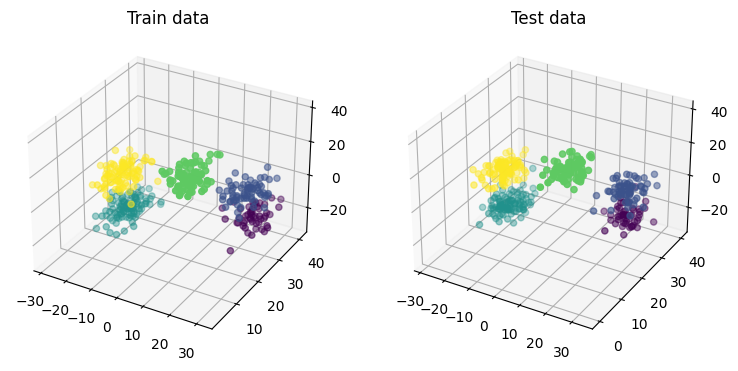

In [535]:
# Create some data with pyclugen
ndims = 3
seed = 123
nclu = 5
npts = 400

direction = [1, 1, 0.5]
angstd = np.pi / 4
csep = [15, 15, 15]
llen = 0.1
llen_std = 0
fat = 3.5

# Train data
data_train = clugen(
    ndims,
    nclu,
    npts,
    direction,
    angstd,
    csep,
    llen,
    llen_std,
    fat,
    point_dist_fn="n",
    rng=rnd.default_rng(seed),
)

# Test data
data_test = clugen(
    ndims,
    nclu,
    npts * 2,
    data_train.directions, # Use final directions in the train data
    angstd,
    csep,
    llen,
    llen_std,
    fat,
    point_dist_fn="n",
    rng=rnd.default_rng(seed * 9 - 27),
    # Overrides from the train data
    clusizes_fn=data_train.sizes,
    clucenters_fn=data_train.centers,
    llengths_fn=data_train.lengths
)

_, axs = plt.subplots(1, 2, figsize=(9, 6), subplot_kw=dict(projection="3d"))
axs[0].scatter(data_train.points[:, 0], data_train.points[:, 1], data_train.points[:, 2], c=data_train.clusters)
axs[0].set_title("Train data")
axs[1].scatter(data_test.points[:, 0], data_test.points[:, 1], data_test.points[:, 2], c=data_test.clusters)
axs[1].set_title("Test data");

In [536]:
def to_nn_output(cg_output: npt.NDArray) -> npt.NDArray:
    """Convert cluster labels to NN output format"""
    nitems = cg_output.shape[0]
    nn_output = np.zeros((nitems, len(np.unique(cg_output))))
    for i in range(nitems):
        nn_output[i, cg_output[i]] = 1
    return nn_output

In [537]:
iters = 60
eta = 0.05
mom = 0.9
topol = [ndims, 18, 18, nclu]

# Convert output to appropriate NN format output
clunn_train = to_nn_output(data_train.clusters)
clunn_test = to_nn_output(data_test.clusters)

# Prepare hooks
fitreg_train = FitnessRegister(data_train.points, clunn_train, iters)
fitreg_test = FitnessRegister(data_test.points, clunn_train, iters)

fitreg_train_m = FitnessRegister(data_train.points, clunn_train, iters)
fitreg_test_m = FitnessRegister(data_test.points, clunn_train, iters)

nn1 = backpropagation(
    data_train.points, clunn_train, topol, iters, eta, hooks=[fitreg_train, fitreg_test]
)
nn2 = backpropagation(
    data_train.points,
    clunn_train,
    topol,
    iters,
    eta,
    momentum=mom,
    hooks=[fitreg_train_m, fitreg_test_m],
)

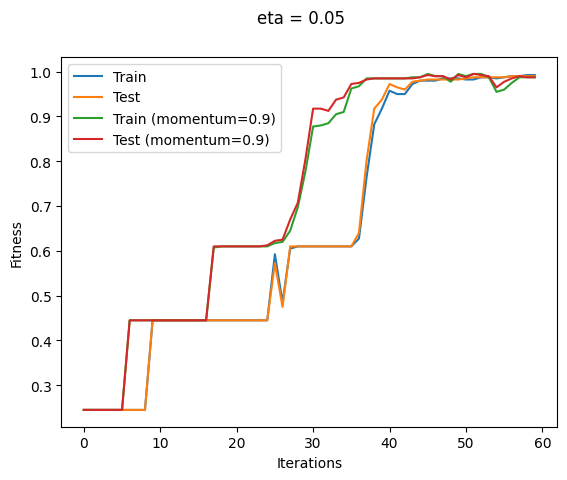

In [538]:
plot_training(
    iters,
    {
        "Train": fitreg_train.fitnesses,
        "Test": fitreg_test.fitnesses,
        f"Train (momentum={mom})": fitreg_train_m.fitnesses,
        f"Test (momentum={mom})": fitreg_test_m.fitnesses,
    },
    f"eta = {eta}",
)